In [1]:
using LinearAlgebra
using Random

In [52]:
sigma = 10.
rho = 28.
beta = 8. / 3.
x0 = [1.5, -1.5, 20.]
t0 = 0.
Δt = 1e-2

A = [
    -sigma sigma 0.;
    rho -1. 0.;
    0. 0. -beta
]

H = zeros(3,9)
H[2,3] = -0.5
H[2,7] = -0.5
H[3,2] = 0.5
H[3,4] = 0.5

function f(x,t)
    return A*x + H*kron(x,x)
end

function jac(x)
    return A + H * kron(I(3),x) + H*kron(x,I(3))
end

jac (generic function with 1 method)

In [17]:
function f2(x,t)
    res = zeros(3)
    res[1] = sigma*(x[2] - x[1])
    res[2] = x[1]*(rho - x[3]) - x[2]
    res[3] = x[1]*x[2] - beta*x[3]
    return res
end

function jac2(x)
    res = zeros(3,3)
    res[1,1] = -sigma
    res[1,2] = sigma
    res[2,1] = rho - x[3]
    res[2,2] = -1.
    res[2,3] = -x[1]
    res[3,1] = x[2]
    res[3,2] = x[1]
    res[3,3] = -beta
    return res
end

jac2 (generic function with 1 method)

In [37]:
function RK4(J, Q, dt)
    # RK4 steps
    k1 = J * Q
    k2 = J * (Q + 0.5*dt*k1)
    k3 = J * (Q + 0.5*dt*k2)
    k4 = J * (Q + dt*k3)
    # Update the perturbation state
    Qnew = Q + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
    return Qnew
end

function lorenz_next(states, time, timestep)
    k1 = f(states, time)
    k2 = f(states + 0.5 * timestep * k1, time + 0.5 * timestep)
    k3 = f(states + 0.5 * timestep * k2, time + 0.5 * timestep)
    k4 = f(states + timestep * k3, time + timestep)
    return states + (timestep / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
end


function posDiag_QR!(Q::AbstractMatrix, R::AbstractMatrix)
    @assert size(Q, 2) == size(R, 2) "Q and R must have the same number of columns"

    m = size(Q, 2)
    for i in 1:m
        if R[i,i] < 0
            Q[:,i] = -Q[:,i]
            R[i,:] = -R[i,:]
        end
    end
end
;

In [60]:
N = 1000
τ = 100
m = 3
uj = x0

λ_all = zeros(m, N)  # all Lyapunov exponents
λ = zeros(m)         # Lyapunov exponents

for t in 0:Δt:τ
    uj = lorenz_next(uj, t, Δt)
end

# Initialize the Q matrix
Q = 100I(m)[:,1:3]  # orthogonal directions

tj = τ
for j in 1:N
    # Compute perturbed states
    Q = RK4(jac(uj), Q, Δt)

    # Update the state values by integrating the model
    uj = lorenz_next(uj, tj, Δt)

    # Orthonormalize the fundamental matrix with the QR decomposition
    QR = LinearAlgebra.qr(Q)
    Q = Matrix(QR.Q)  # update the Q matrix
    R = QR.R          # obtain the R matrix (upper triangular: expansion/contraction rates)
    posDiag_QR!(Q, R) # make sure the diagonal of R is positive
    Q = Q[:, 1:m]     # truncate Q to the first m columns
    R = R[1:m, 1:m]   # truncate R to the first m rows and columns

    # add to the Lyapunov exponents
    λ .+= log.(diag(R))
    λ_all[:,j] = λ / j / Δt

    # update time
    tj += Δt
end
λ ./= N * Δt

3-element Vector{Float64}:
   1.091578882455932
   0.47624433798314303
 -13.852843952997356

In [54]:
using Plots

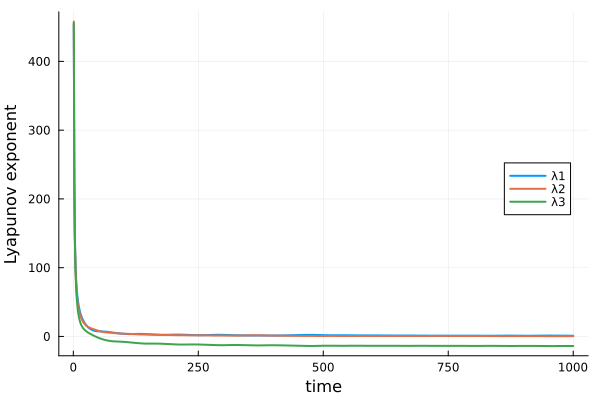

In [61]:
p = plot()
for i in 1:m
    plot!(p, λ_all[i,:], label="λ$i", lw=2)
end
plot!(p, xlabel="time", ylabel="Lyapunov exponent", legend=:right)
display(p)

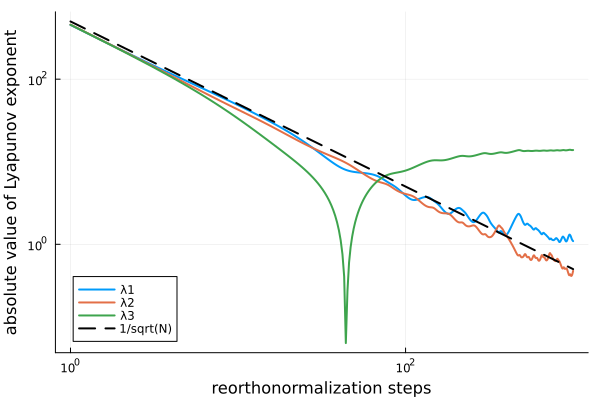

In [78]:
p = plot()
for i in 1:m
    plot!(p, abs.(λ_all[i,:]), label="λ$i", lw=2)
end
plot!(p, 500 ./ (1:N), label="1/sqrt(N)", lw=2, ls=:dash, c=:black)
plot!(xscale=:log10, yscale=:log10)
plot!(p, xlabel="reorthonormalization steps", ylabel="absolute value of Lyapunov exponent", legend=:bottomleft)
display(p)